In [167]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import path, listdir
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import polyline
import requests

### Load activities

In [168]:
DIRECTORY = 'activities/'
FIGURES = 'figures/'
COLOR = sns.color_palette("YlOrBr_r") #viridis_r
ELEV_API = 'https://api.opentopodata.org/v1/srtm30m'
df = pd.DataFrame()
for file in listdir(DIRECTORY):
    new_df = pd.read_json(path.join(DIRECTORY, file))
    df = df.append(new_df)

df = df.reset_index()


### Data cleaning

In [169]:
df['distance'] = df['distance'] / 1000 # meters to km
df['moving_time'] = df['moving_time'].apply(pd.to_timedelta, unit='s')
df['elapsed_time'] = df['elapsed_time'].apply(pd.to_timedelta, unit='s')
df['start_date'] = pd.to_datetime(df['start_date'])
df['average_speed'] = df['average_speed'] * 3.6 # m/s to km/h
df['max_speed'] = df['max_speed'] * 3.6 # m/s to km/h
df['avg_pace'] = 60 / df['average_speed']
df['avg_pace'].replace([np.inf, -np.inf], 0, inplace=True)
df['avg_pace'] = df['avg_pace'] #.apply(pd.to_timedelta, unit='m')


### Sport counts by year

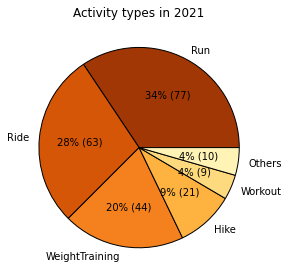

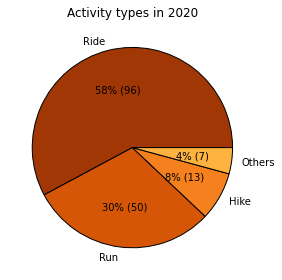

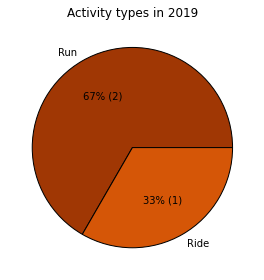

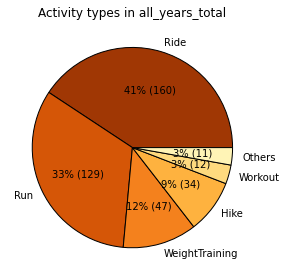

In [170]:
# Create pie chart labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.0f}% ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Create years and dataframes for pie charts
years = df['start_date'].dt.year.unique()
dfs = []
for year in years:
    dfs.append(df[df['start_date'].dt.year == year])
dfs.append(df.copy())
years = np.append(years, 'all_years_total')

# Chart for each dataframe
for year, df_iter in zip(years, dfs):
    type_count = df_iter['type'].value_counts()
    small_cols = type_count < type_count.sum() * 0.03
    others = type_count[small_cols].sum()
    if others != 0:
        type_count = type_count[~small_cols]
        type_count['Others'] = others
    fig = plt.figure()
    ax = fig.gca()
    ax = plt.pie(type_count, labels = type_count.index, 
                 autopct=make_autopct(type_count), 
                 colors=COLOR)
    plt.title(f"Activity types in {year}")
    plt.tight_layout()
    plt.savefig(path.join(FIGURES, f"sport_types_{year}"), dpi=800)



### Total info - maxes

In [171]:
max_dist = df['distance'].max()
longest_time = df['moving_time'].max()
heighest_point = df['elev_high'].max()
print(f'Heighest point[M]: {heighest_point}')
print(f'Longest activity[H]: {longest_time}')
print(f'Longest distance[KM]: {max_dist}')

print('Run statistics:')
print(df[df['type'] == 'Run']['distance'].describe())

summed = df['total_elevation_gain'].sum()
print(f'Total elevation gained[M]: {summed}')

Heighest point[M]: 2293.6
Longest activity[H]: 0 days 11:28:02
Longest distance[KM]: 100.536
Run statistics:
count    129.000000
mean       9.163219
std        4.212749
min        2.135400
25%        6.179300
50%        8.349600
75%       11.007400
max       25.453900
Name: distance, dtype: float64
Total elevation gained[M]: 135164.2


### Records by sport

In [172]:
stats_dict = {}
types = ['Run', 'Ride', 'Hike']
for sport in types:
    sport_df = df[df['type'] == sport]
    STATS = ['moving_time', 'elapsed_time', 'distance', 
            'total_elevation_gain', 'average_speed',
            'average_heartrate', 'kudos_count']
    sport_stats = {}
    for stat in STATS:
        sport_stats[f"{stat}_max"] = sport_df[f"{stat}"].max()
        sport_stats[f"{stat}_avg"] = sport_df[f"{stat}"].mean()
    if sport == 'Run':
        sport_stats["pace_min"] = sport_df["avg_pace"].min()
        sport_stats["pace_avg"] = sport_df["avg_pace"].mean()
    stats_dict[sport] = sport_stats

display(stats_dict)

{'Run': {'moving_time_max': Timedelta('0 days 02:44:44'),
  'moving_time_avg': Timedelta('0 days 00:55:25.465116279'),
  'elapsed_time_max': Timedelta('0 days 02:54:39'),
  'elapsed_time_avg': Timedelta('0 days 00:57:37.356589147'),
  'distance_max': 25.4539,
  'distance_avg': 9.16321937984496,
  'total_elevation_gain_max': 853.1,
  'total_elevation_gain_avg': 147.30620155038758,
  'average_speed_max': 12.4308,
  'average_speed_avg': 10.189897674418605,
  'average_heartrate_max': 180.4,
  'average_heartrate_avg': 158.79140625000002,
  'kudos_count_max': 11,
  'kudos_count_avg': 4.744186046511628,
  'pace_min': 4.826720725938797,
  'pace_avg': 5.9471289506352125},
 'Ride': {'moving_time_max': Timedelta('0 days 06:07:44'),
  'moving_time_avg': Timedelta('0 days 01:48:40.437500'),
  'elapsed_time_max': Timedelta('0 days 07:12:32'),
  'elapsed_time_avg': Timedelta('0 days 02:05:05.693750'),
  'distance_max': 100.536,
  'distance_avg': 23.814288749999996,
  'total_elevation_gain_max': 2667.

### Correlation between average pace and average heart rate

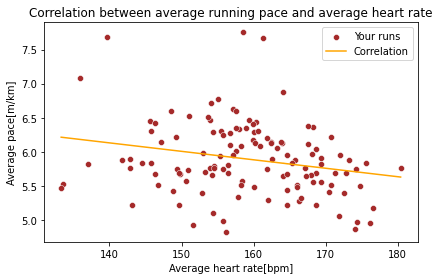

In [173]:
df_tmp = df[df['type'] == 'Run']

# DROP NA, INF, 0.0
df_tmp = df_tmp[~df_tmp['avg_pace'].isin([np.nan, np.inf, 0.0])]
df_tmp = df_tmp[~df_tmp['average_heartrate'].isin([np.nan, np.inf, 0.0])]
df_tmp = df_tmp[['avg_pace', 'average_heartrate']]
# remove outlier values
df_tmp = df_tmp[(np.abs(stats.zscore(df_tmp)) < 3).all(axis=1)]

# reshape and fit regression model
avg_hr = df_tmp['average_heartrate'].to_numpy().reshape(-1, 1)
avg_pace = df_tmp['avg_pace'].to_numpy().reshape(-1, 1)
lr = LinearRegression().fit(avg_hr, avg_pace)
predict = lr.predict(avg_hr)

# plot
sns.scatterplot(data=df_tmp, x='average_heartrate', y='avg_pace', color='brown')
sns.lineplot(x=avg_hr.reshape(1, -1)[0], y=predict.reshape(1, -1)[0], color='orange')
plt.legend(['Your runs', 'Correlation'])
plt.title('Correlation between average running pace and average heart rate')
plt.xlabel('Average heart rate[bpm]')
plt.ylabel('Average pace[m/km]')
plt.tight_layout()
plt.savefig(path.join(FIGURES,"hr_pace_correlation"), dpi=800)


### Plot elevation profile from an activity json

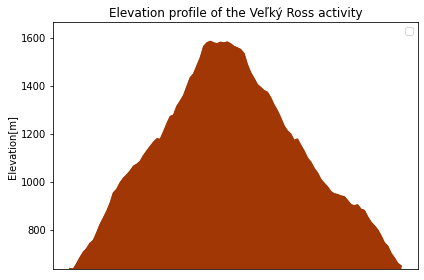

In [179]:
def plot_elev_profile(file):
   with open(file, 'r') as f:
      jsn = json.load(f)
   polylinez = jsn['map']['polyline']
   coords = polyline.decode(polylinez)
   # sample exactly 100 coords - API limit
   sample_coords = coords[::int(round(len(coords)/100))]
   if len(sample_coords) > 100:
      sample_coords = sample_coords[0:100]
   data = requests.get(
      ELEV_API,
      params={'locations': polyline.encode(sample_coords)}
   ).json()
   elev = []
   for item in data['results']:
      elev.append(item['elevation'])
   df_new = pd.DataFrame()
   df_new['elevation'] = pd.Series(elev)
   df_new.plot.area(color=COLOR)
   plt.legend('')
   plt.xticks([])
   plt.ylim(df_new['elevation'].min())
   plt.ylabel('Elevation[m]')
   plt.title(f"Elevation profile of the {jsn['name']} activity")
   plt.tight_layout()
   plt.savefig(path.join(FIGURES,"elevation_profile_{}.png"), dpi=800)

plot_elev_profile('act1.json')

### Trail/Road run classificator dataset, and scores

In [175]:
# annote runs(1==trail, 0==road)
def make_classificator_dataset():
     classificator_df = df[df['type'] == 'Run']
     trail_runs = np.array([1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,
                            1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,
                            1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,
                            0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,
                            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                            0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,
                            1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                            0,0,0])
     classificator_df['trail_run'] = trail_runs
     columns = ['id', 'name', 'total_elevation_gain', 'avg_pace', 'average_heartrate', 'elev_high', 'trail_run']
     classificator_df = classificator_df[columns]
     classificator_df = classificator_df.reset_index()
     classificator_df.to_csv('trail_classificator_dataset.csv')

# create dataset and save to csv
if not path.isfile('trail_classificator_dataset.csv'):
     make_classificator_dataset()

# extract features and split dataset into training and testing subsets
classificator_df = pd.read_csv('trail_classificator_dataset.csv')
feature_names = ['total_elevation_gain', 'elev_high', 'avg_pace', 'average_heartrate'] #mozno suffer score
features = classificator_df[feature_names]
response_var = classificator_df['trail_run']
nans = features[features.isnull().any(axis=1)]
features = features[~features.index.isin(nans.index)]
response_var = response_var[~response_var.index.isin(nans.index)]
X_train, X_test, y_train, y_test = train_test_split(features, response_var, random_state=0)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

classificators = [LogisticRegression(),
                  DecisionTreeClassifier(),
                  LinearDiscriminantAnalysis(),
                  KNeighborsClassifier(), 
                  GaussianNB(), 
                  SVC()]
names = ['Logistic regression', 
         'Decision Tree',
         'Linear Discriminant Analysis',
         'K-Nearest Neighbors',
         'Gaussian Naive Bayes',
         'C-Support Vector']

# evaluate different models
for classificator, name in zip(classificators, names):
     classificator.fit(X_train, y_train)
     print(f'Accuracy of {name} classifier on training set: {classificator.score(X_train, y_train):.2f}')
     print(f'Accuracy of {name} classifier on test set: {classificator.score(X_test, y_test):.2f}\n')

knn = classificators[3]
test_predicts = knn.predict(X_test)
train_predicts = knn.predict(X_train)

Accuracy of Logistic regression classifier on training set: 0.94
Accuracy of Logistic regression classifier on test set: 0.91

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.88

Accuracy of Linear Discriminant Analysis classifier on training set: 0.93
Accuracy of Linear Discriminant Analysis classifier on test set: 0.91

Accuracy of K-Nearest Neighbors classifier on training set: 0.93
Accuracy of K-Nearest Neighbors classifier on test set: 0.94

Accuracy of Gaussian Naive Bayes classifier on training set: 0.92
Accuracy of Gaussian Naive Bayes classifier on test set: 0.88

Accuracy of C-Support Vector classifier on training set: 0.88
Accuracy of C-Support Vector classifier on test set: 0.91



### Show incorrectly classified runs

Incorrectly predicted train data


,index_left,total_elevation_gain,elev_high,avg_pace,average_heartrate,index,id,name,trail_run,predicted_trail_run
6,3,183.9,322.5,5.727377,150.9,3,6382798181,Afternoon Run,0,1
12,62,104.7,410.2,5.950256,164.6,62,4791519494,Afternoon Run,1,0
39,0,176.2,419.0,5.883045,141.7,0,6413878675,Morning Run,1,0
42,55,205.4,449.9,5.486065,160.0,55,4934430913,Afternoon Run,0,1
44,23,179.8,344.7,6.298816,145.8,23,6026300681,Brdky,1,0
54,106,140.4,318.4,5.901794,162.6,106,3622154087,Morning Run,1,0
69,25,129.0,312.9,5.400734,152.8,25,5999926383,Morning Run,1,0


Incorrectly predicted test data


,index_left,total_elevation_gain,elev_high,avg_pace,average_heartrate,index,id,name,trail_run,predicted_trail_run
7,96,98.5,403.9,5.967299,168.1,96,3939441912,Morning Run,1,0
23,68,191.0,283.2,6.209637,161.8,68,4669275992,Afternoon Run,0,1


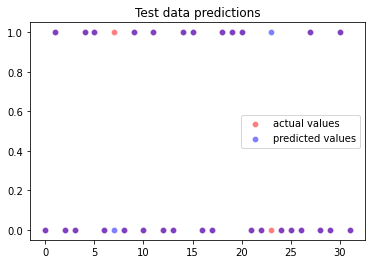

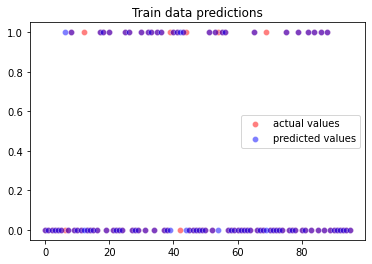

In [176]:
# 1 = trail run, 0 = road run
axes = plt.figure().gca()
sns.scatterplot(data=y_test.values, color='r', alpha=0.5, ax=axes)
sns.scatterplot(data=test_predicts, color='b', alpha=0.5, ax=axes)
plt.legend(['actual values', 'predicted values'])
plt.title('Test data predictions')

axes = plt.figure().gca()
sns.scatterplot(data=y_train.values, color='r', alpha=0.5, ax=axes)
sns.scatterplot(data=train_predicts, color='b', alpha=0.5, ax=axes)
plt.legend(['actual values', 'predicted values'])
plt.title('Train data predictions')

X_test_r = X_test.reset_index()
X_train_r = X_train.reset_index()
classificator_df_r = classificator_df.drop(['index', 'Unnamed: 0'], axis=1)
classificator_df_r = classificator_df_r.reset_index()

named_train_X = X_train_r.join(classificator_df_r[['index', 'id', 'name', 'trail_run']], on='index', how='left', lsuffix='_left')
named_test_X = X_test_r.join(classificator_df_r[['index', 'id', 'name', 'trail_run']], on='index', how='left', lsuffix='_left')
named_test_X['predicted_trail_run'] = test_predicts
named_train_X['predicted_trail_run'] = train_predicts


mask = y_train.values != train_predicts
print('Incorrectly predicted train data')
display(named_train_X[mask]) # incorrectly predicted train data

mask = y_test.values != test_predicts
print('Incorrectly predicted test data')
display(named_test_X[mask]) # incorrectly predicted test data


### Add trail predictions to dataframe and plot pace distribution by run type

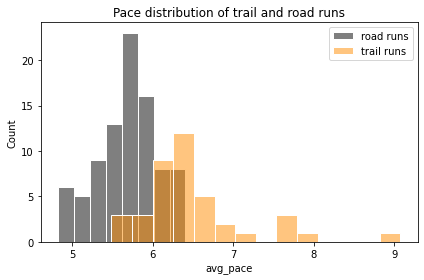

In [177]:
run_df = df[df['type'] == 'Run']
full_features = run_df[['total_elevation_gain', 'elev_high', 'avg_pace', 'average_heartrate']]
# remove missing values
nans = full_features[full_features.isnull().any(axis=1)]
full_features = full_features[~full_features.index.isin(nans.index)]
run_df = run_df[~run_df.index.isin(nans.index)]
predictions = knn.predict(full_features)
run_df['trail_run'] = predictions


trail_df = run_df[run_df['trail_run'] == 1]
road_df = run_df[run_df['trail_run'] == 0]

sns.histplot(data=road_df['avg_pace'], color='black', alpha=0.5, edgecolor="white")
sns.histplot(data=trail_df['avg_pace'], color='darkorange', alpha=0.5, edgecolor="white")
plt.title('Pace distribution of trail and road runs')
plt.legend(['road runs', 'trail runs'])
plt.tight_layout()
plt.savefig(path.join(FIGURES,"pace_distribution.png"), dpi=800)

### Make top X lists

In [178]:
def make_topX(sub_df, column, X, ascending=False):
    topX = sub_df[column].sort_values(ascending=ascending)[0:X]
    topX = pd.DataFrame(topX)
    names = df.iloc[topX.index]['name'].values
    topX['name'] = names
    ids = df.iloc[topX.index]['id'].values
    topX['id'] = ids
    return topX

df_run = df[df['type'] == 'Run']

print('Fastest runs:')
display(make_topX(df_run, 'avg_pace', 5, True))
print('Longest runs:')
display(make_topX(df_run, 'distance', 5, False))

df_bike = df[df['type'] == 'Ride']

print('Biggest elevation gain on a bike:')
display(make_topX(df_bike, 'total_elevation_gain', 10, False))
print('Max distance on a bike:')
display(make_topX(df_bike, 'distance', 5, False))

Fastest runs:


,avg_pace,name,id
188,4.826721,"Najprv pracovne točiť na bakalárku, potom 5k e...",4907039507
268,4.870446,Golden hour v Brne,4059286759
347,4.929508,Running,3440611876
315,4.963272,Rýchlosť v daždi,3688815417
284,4.964750,Afternoon Run,3931734333


Longest runs:


,distance,name,id
1,25.4539,Lelekovice hrad,6397787893
39,21.3156,Trailová polka,6051280034
289,21.2089,Rajecký polmaratón 2020,3881871486
352,21.0162,Prvý polmaratón,3365001491
173,17.5223,Kunerad Trail Run,4971362999


Biggest elevation gain on a bike:


,total_elevation_gain,name,id
300,2667.0,Gerlaching @Mtbiker,3790027833
100,1844.0,Bikepark Jasenská,5424977173
105,1394.5,Minčol - Polom - Strečno hrebienok,5365807463
108,1214.3,Kunerad a pár noviniek,5333667139
75,1175.7,Back. In. Business.,5752513841
299,1168.4,Singletrails Lechnica,3811523430
156,1145.1,Jarný Kunerad,5049336582
71,1137.1,Taipan vyškolí,5779895193
53,1132.2,Kunerad 🖤,5947724485
102,1093.7,Krížava - martinské traily,5405686181


Max distance on a bike:


,distance,name,id
65,100.5360,Čičmany,5833278773
244,92.3955,Kasárne Makov,4302242690
122,83.5440,Rakytie - Hričov - Lietava,5240182205
300,81.9797,Gerlaching @Mtbiker,3790027833
118,69.1993,...,5267006712
